In [1]:
import numpy as np
import scipy.misc
import scipy.ndimage.filters
import matplotlib.pyplot as plt
import pylab
from numbers import Number
%matplotlib inline
pylab.rcParams['figure.figsize'] = (15, 10.0)


(1110, 1282, 3) float64


/usr/lib/python2.7/dist-packages/scipy/ndimage/interpolation.py:532: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


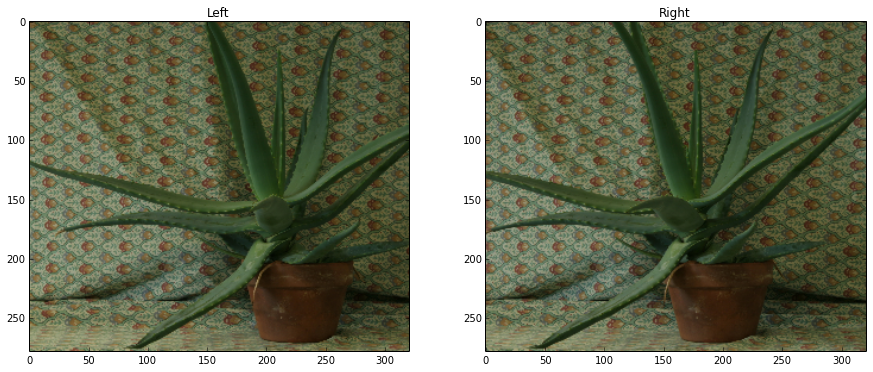

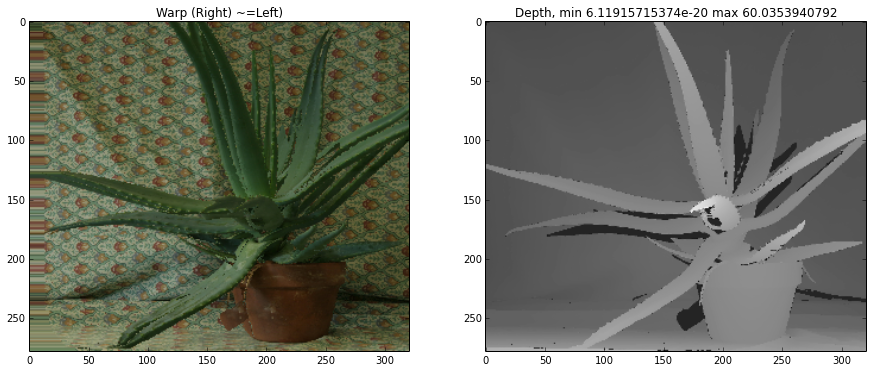

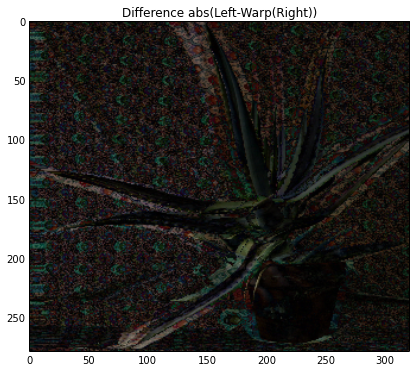

In [2]:
def rescale(scale, left, right, depth):
    '''
    Rescale left, and right images.
    Rescale disparity map and adapt disparities (since they are in pixels).
    '''
    if scale != 1.:
        # resize converts all to 0.255 chars, so use zoom instead
        left = scipy.ndimage.interpolation.zoom(left, [scale, scale, 1])
        right = scipy.ndimage.interpolation.zoom(right, [scale, scale, 1])
        depth = scipy.ndimage.interpolation.zoom(depth, scale) * scale
    return left, right, depth

def rescale_shape(shape, left, right, depth):
    '''
    Rescale left, and right images.
    Rescale disparity map and adapt disparities (since they are in pixels).
    '''
    # resize converts all to 0.255 chars, so use zoom instead
    left = scipy.ndimage.interpolation.zoom(left, [scale, scale, 1])
    right = scipy.ndimage.interpolation.zoom(right, [scale, scale, 1])
    depth = scipy.ndimage.interpolation.zoom(depth, scale) * scale
    return left, right, depth


def warp(left, right, depth):
    '''
    Rewarp right image to left
    '''
    warped = np.zeros_like(left)
    for i in xrange(depth.shape[0]):  # iterate on rows only
        #for j in xrange(depth.shape[1]):
        identity = np.arange(depth.shape[1])
        warped[i] = np.take(right[i], identity-depth[i].astype(int), axis=0, mode='clip')
    warped[depth==0] = 0  # apply mask
    return warped

# Rewarp right image to left
def warp_slow(left, right, depth):
    warped = np.zeros_like(left)
    for i in xrange(depth.shape[0]):  # iterate on rows only
        for j in xrange(depth.shape[1]):
            warped[i, j] = right[i, np.clip(j-int(depth[i, j]), 0, depth.shape[1]-1)]
            if depth[i, j] == 0:
                warped[i, j] = 0
    return warped

# Load data
left = scipy.misc.imread('../data/cones/im2.png').astype(float)/255.
right = scipy.misc.imread('../data/cones/im6.png').astype(float)/255.
depth = scipy.misc.imread('../data/cones/disp2.png').astype(float)/4.  # middlebury

left = scipy.misc.imread('../data/tsukuba/scene1.row3.col3.ppm').astype(float)/255.
right = scipy.misc.imread('../data/tsukuba/scene1.row3.col1.ppm').astype(float)/255.
depth = -scipy.misc.imread('../data/tsukuba/truedisp.row3.col3.pgm').astype(float)/8.  # cdi picture

left = scipy.misc.imread('../data/aloe/view0.png').astype(float)/255.
right = scipy.misc.imread('../data/aloe/view5.png').astype(float)/255.
depth = scipy.misc.imread('../data/aloe/disp1.png').astype(float)  # middlebury


if len(depth.shape) > 2:
    depth = depth.mean(axis=2)

print left.shape, left.dtype
# recale
scale = 0.25
left, right, depth = rescale(scale, left, right, depth)

# warp right image to left
warped = warp(left, right, depth)
    
# Plot
plt.subplot(121)
plt.imshow(left)
plt.title('Left')

plt.subplot(122)
plt.imshow(right)
plt.title('Right')

plt.figure()
plt.subplot(121)
plt.imshow(warped, cmap='gray')
plt.title('Warp (Right) ~=Left)')

plt.subplot(122)
plt.imshow(depth, cmap='gray')
plt.title('Depth, min {} max {}'.format(depth[depth>0].min(), depth.max()))

plt.figure()
plt.subplot(121)
plt.imshow(np.abs(warped-left), cmap='gray')
plt.title('Difference abs(Left-Warp(Right))')

In [3]:
def make_variational(disparity, gammas):
    '''
    Transform a 2D disparity matrix u into
    a 3D tensor representing the character
    '''
    phi = np.zeros((disparity.shape[0], disparity.shape[1], len(gammas)))
    for i, gamma in enumerate(gammas):
        phi[..., i] = disparity >= gamma
    return phi.astype(float)


def compare(left, right, gammas, norm=1):
    '''
    Parameters
    ----------
    left, right : array of shape (height, width, channels)
        images to compare
    gammas : list of float
        possible values of disparity map
        for a perfect match, we would have
            left[i, j] == right[i, j - disparity[i, j]]
        
    Returns
    -------
    rho : array of shape (height, width, len(gammas))
        dissimilarity rho[i, j, gamma] == || left[i, j] - right[i, j - gamma] ||
    '''
    rho = np.zeros((left.shape[0], left.shape[1], len(gammas)))
    for k, gamma in enumerate(gammas):
        for i in xrange(left.shape[0]):  # iterate on rows only
            identity = np.arange(left.shape[1])
            warped_row = np.take(right[i], identity-int(gamma), axis=0, mode='clip')
            rho[i, :, k] = np.linalg.norm(warped_row - left[i], norm, axis=-1)  # sum on channels
    return rho


def project_p(p, rho):
    '''
    Project the dual variable (function) p on set C, where
        C = {p: Image -> R^3 | ||(p1, p2)(x, gamma)|| <= 1, |p3| <= rho(x, gamma)}

    This amounts to projecting independently for each tuple (x, gamma).
        
    Warning!! This used to be implemented using double slicing.
    NEVER USE DOUBLE SLICING.
        
    Parameters
    ----------
    p : array of shape (height, width, len(gammas), 3)
        primal variable, to be projected
    rho : array of shape (height, width, len(gammas))
        dissimilarity between left and warped right views
        
    Returns
    -------
    projected_p : array of same shape as p 
        projected p
    '''
    proj_p = np.array(p)
    norms12 = np.linalg.norm(p[:, :, :, :2], axis=3)
    norms3 = np.abs(p[:, :, :, 2])
    mask12 = norms12 > 1
    mask3 = norms3 > rho
    proj_p[mask12, :2] /= norms12[mask12, np.newaxis]
    proj_p[mask3, 2] *= rho[mask3]/norms3[mask3]
    return proj_p


def project_p_naive(p, rho):
    '''
    Does same thing as project_p, for debugging purposes
    '''
    proj_p = np.array(p)
    for i in xrange(p.shape[0]):
        for j in xrange(p.shape[1]):
            for k in xrange(p.shape[2]):
                norm12 = np.linalg.norm(p[i, j, k, :2])
                if norm12 > 1.:
                    proj_p[i, j, k, :2] /= norm12
                norm3 = np.abs(p[i, j, k, 2])
                if norm3 > rho[i, j, k]:
                    proj_p[i, j, k, 2] *= rho[i, j, k] / norm3
    return proj_p

    
def project_phi(phi):
    '''
    Project the primal variable (function) phi on the set D, where
        D = {phi: Image x Gammas -> [0, 1] | phi(*, min(gamma)) = 1, phi(*, max(gamma)) = 0 }
        
    This amounts to:
    - clamp all values to [0, 1]
    - set the min(gamma), and max(gamma) valeus to 1 and 0
    
    Parameters
    ----------
    phi : array of shape (height, width, len(gammas))
        dual variable, to be projected
        
    Returns
    -------
    proj_phi : array of same shape as p
        projected phi
    '''
    proj_phi = np.asarray(phi)
    proj_phi = np.clip(phi, 0, 1)
    proj_phi[..., 0] = 1
    proj_phi[..., -1] = 0
    return proj_phi


def get_initial_phi(image, gammas):
    return np.zeros((left.shape[0], left.shape[1], len(gammas)))        


def get_initial_p(image, gammas):
    return np.zeros((left.shape[0], left.shape[1], len(gammas), 3))


def get_grad(phi, step_gamma=1.):
    '''
    TODO take gamma step
    
    Compute gradient of phi along each direction (width, height, gammas)
    
    Parameters
    ----------
    phi : array of shape (height, width, len(gammas))
        dual variable
    step_gamma : float
        distance between gammas
        
    Returns
    -------
    grad_phi : array of shape (height, width, len(gammas), 3)
        gradient of phi
    '''
    dheight, dwidth, dgamma = np.gradient(phi)
    dgamma /= step_gamma
    grad_phi = np.rollaxis(np.array((dheight, dwidth, dgamma)), 0, len(phi.shape)+1)
    return grad_phi


def get_grad_with_diff(phi, step_gamma=1.):
    '''
    Same as get_grad using FORWARD differences
    '''
    dheight = phi[1:, :, :] - phi[:-1, :, :]
    dwidth = phi[:, 1:, :] - phi[:, :-1, :]
    dgamma = phi[:, :, 1:] - phi[:, :, :-1]
    # fix borders (add in front for FORWARD)
    dheight = np.concatenate((dheight, dheight[-1:, :, :]), axis=0)
    dwidth = np.concatenate((dwidth, dwidth[:, -1:, :]), axis=1)
    dgamma = np.concatenate((dgamma, dgamma[:, :, -1:]), axis=2)
    
    grad_phi = np.rollaxis(np.array((dheight, dwidth, dgamma)), 0, len(phi.shape)+1)
    return grad_phi


def get_div(p, step_gamma=1.):
    '''
    Compute divergence of p along each directions (width, height, gammas),
    which is at each point:
        dp_0/dwidth + dp_1/dheight + dp_2/dgamma
    
    Parameters
    ----------
    p : array of shape (height, width, len(gammas), 3)
        primal variable
    step_gamma : float
        distance between gammas
        
    Returns
    -------
    div_p : array of shape (height, width, len(gammas))
        divergence of p
    '''
    grads = np.gradient(p)
    dheight, dwidth, dgamma = grads[:-1]
    div_p = dheight[..., 0] + dwidth[..., 1] + dgamma[..., 2] / step_gamma
    return div_p

def get_div_with_diff(p, step_gamma=1.):
    '''
    Same as get_div using backward differences
    
    #TEST SIMILAR
    p = np.arange(3*2*4*3).reshape((3,2,4,3))**2
    print 'p',p[:, :, :, 0]
    grads = np.gradient(p)
    dheight_fast, dwidth_fast, dgamma_fast = grads[:-1]

    dheight = p[1:, :, :, 0] - p[:-1, :, :, 0]
    dwidth = p[:, 1:, :, 1] - p[:, :-1, :, 1]
    dgamma = p[:, :, 1:, 0] - p[:, :, :-1, 2]
    # fix borders (add in front for backward)
    dheight = np.concatenate((dheight[:1, :, :], dheight), axis=0)
    dwidth = np.concatenate((dwidth[:, :1, :], dwidth), axis=1)
    dgamma = np.concatenate((dgamma[:, :, :1], dgamma), axis=2)

    print 'fast',dheight_fast[:,:,:,0]
    print 'naive',dheight    
    '''
    dheight = p[1:, :, :, 0] - p[:-1, :, :, 0]
    dwidth = p[:, 1:, :, 1] - p[:, :-1, :, 1]
    dgamma = p[:, :, 1:, 2] - p[:, :, :-1, 2]
    # fix borders (add in front for backward)
    dheight = np.concatenate((dheight[:1, :, :], dheight), axis=0)
    dwidth = np.concatenate((dwidth[:, :1, :], dwidth), axis=1)
    dgamma = np.concatenate((dgamma[:, :, :1], dgamma), axis=2)
    
    div_p = dheight + dwidth + dgamma / step_gamma
    return div_p

class VariationalStereo(object):
    '''
    Example
    =======
    1. Create the object
    
        stereo = VariationalStereo()
    
    2. Initialize using either
        option a. Initialize manually by setting values for primal and dual variables

            stereo.init_manual(phi, p, rho, gammas)

        option b. Initialize automatically by computing phi, p, and rho from
        the input images

            stereo.init_auto(left, right, lbda)

    3. Alternate primal and dual steps
    
        for epoch in xrange(epochs):
            stereo.step_primal()
            stereo.step_dual()
        
    '''
    def init_manual(self, phi, p, rho, gammas, tau_phi=1./np.sqrt(3), tau_p=1./np.sqrt(3)):
        self.phi = np.array(phi)
        self.p = np.array(p)
        self.rho = np.array(rho)
        self.gammas = gammas
        self.step_gamma = gammas[1] - gammas[0]
        self.tau_phi = tau_phi
        self.tau_p = tau_p
        self.reset_logs()
        return self
        
    def init_auto(self, left, right, lbda, gammas, **kwargs):
        '''
        From left and right images compute and set phi, p, and rho
        '''
        phi = get_initial_phi(left, gammas)
        p = get_initial_p(left, gammas)
        rho = lbda * compare(left, right, gammas)
        self.init_manual(phi, p, rho, gammas, **kwargs)
        return self

    def reset_logs(self):
        self.cost_data = []
        self.cost_regular = []
        self.dst_truth = []
        self.lagrangian_after_primal = []
        self.lagrangian_after_dual = []
        self.cost = []
        
    def get_lagrangian(self):
        return np.sum(self.grad_phi * self.p)
        
    def step_primal(self):
        # Primal step
        self.div_p = get_div_with_diff(self.p, self.step_gamma)
        self.phi = project_phi(self.phi + self.tau_phi * self.div_p)  
        self.grad_phi = get_grad_with_diff(self.phi, self.step_gamma)
        self.lagrangian_after_primal_ = self.get_lagrangian()
    
    def step_dual(self):
        # Dual Step
        self.p = project_p(self.p + self.tau_p * self.grad_phi, self.rho)   
        self.lagrangian_after_dual_ = self.get_lagrangian()
        
    def update_stats(self, true_disparity):
        # Recompute disparity
        self.disparity = np.min(self.gammas) + self.step_gamma * np.sum(self.phi > 0.5, axis=2)

        # Compute distance to actual map
        self.dst_truth_ = np.mean(np.abs(self.disparity - true_disparity)[true_disparity!=0])

        # Compute variational cost are minimizing
        self.cost_regular_ = np.sum(np.linalg.norm(self.grad_phi, axis=3))
        self.cost_data_ = np.sum(self.rho * np.abs(self.grad_phi[:, :, :, 2]))
        
        # Append (tied together so that KeyboardInterrupt is unlikely to interrupt)
        self.lagrangian_after_primal.append(self.lagrangian_after_primal_)
        self.lagrangian_after_dual.append(self.lagrangian_after_dual_)
        self.cost_regular.append(self.cost_regular_)
        self.cost_data.append(self.cost_data_)
        self.cost.append(self.cost_regular_ + self.cost_data_)
        self.dst_truth.append(self.dst_truth_)
        
    def print_stats(self):
        try:
            print 'lagrangian after primal', self.lagrangian_after_primal[-1]
            print 'lagrangian after dual', self.lagrangian_after_dual[-1]
            print 'duality gap', self.lagrangian_after_dual[-1]-self.lagrangian_after_primal[-1]
            print 'regular-cost', self.cost_regular[-1]
            print 'data-cost', self.cost_data[-1]
            print 'total-cost', self.cost[-1]
            print 'Distance to truth', self.dst_truth[-1]        
        except Exception as e:
            print '<No Stats>', e
        
def plot_summary(variational_stereo, true_disparity=None):
    vs = variational_stereo
    if true_disparity is None:
        true_disparity = np.array(vs.disparity)

    plt.subplot(121)
    plt.plot(np.arange(len(vs.cost_regular)), vs.cost_regular, label='regularization')
    plt.plot(np.arange(len(vs.cost_data)), vs.cost_data, label='data')
    plt.plot(np.arange(len(vs.cost)), vs.cost, label='total (variational) cost')
    plt.legend()
    plt.xlabel('epoch')
    plt.title('Regularization and Data Costs')

    plt.subplot(122)
    plt.plot(np.arange(len(vs.dst_truth)), vs.dst_truth, label='Absolute Pixel-wise')
    plt.xlabel('epoch')
    plt.title('Distance to Truth')
    plt.legend()

    plt.figure()
    plt.plot(np.arange(len(vs.lagrangian_after_primal)), vs.lagrangian_after_primal, label='total (primal-dual) after primal')
    plt.plot(np.arange(len(vs.lagrangian_after_dual)), vs.lagrangian_after_dual, label='total (primal-dual) after dual')
    plt.plot(np.arange(len(vs.lagrangian_after_primal)), np.asarray(vs.lagrangian_after_dual)-np.asarray(vs.lagrangian_after_primal), 
             label='duality gap')
    plt.title('Duality Gap')
    plt.legend()

    plt.figure()
    plt.subplot(121)
    plt.imshow(vs.disparity, vmin=true_disparity.min(), vmax=true_disparity.max())
    plt.title('Predicted')
    
    plt.subplot(122)
    plt.imshow(true_disparity, vmin=true_disparity.min(), vmax=true_disparity.max())
    plt.title('True')

    plt.figure()
    #plt.subplot(121)
    plt.imshow(np.abs(true_disparity-vs.disparity), vmin=true_disparity.min(), vmax=true_disparity.max())
    plt.title('Absolute Difference')
    plt.colorbar()

In [4]:
# Method from Pock (2008)
gammas = np.arange(np.floor(np.min(depth)), np.ceil(np.max(depth)), 1)  # set of gammas to try
ref_height = 375.
lbda = 30. * left.shape[0] / ref_height  # trades off regularity and data term

print 'lambda', lbda
print 'gammas', gammas

########################
stereo = VariationalStereo().init_auto(left, right, lbda, gammas)
epochs = 1000
for epoch in xrange(epochs):
    stereo.step_primal()
    stereo.step_dual()
    stereo.update_stats(depth)
    if epoch % 50 == 0:
        print '\nEpoch {}/{}'.format(epoch, epochs)
        stereo.print_stats()

lambda 22.24
gammas [-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.
   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.
  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.
  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.]

Epoch 0/1000
lagrangian after primal 0.0
lagrangian after dual 51390.717183
duality gap 51390.717183
regular-cost 89238.0
data-cost 648940.747903
total-cost 738178.747903
Distance to truth 26.4546557252

Epoch 50/1000
lagrangian after primal 39663.2714078
lagrangian after dual 49893.9968263
duality gap 10230.7254185
regular-cost 117402.588736
data-cost 576000.327027
total-cost 693402.915763
Distance to truth 6.59092313717

Epoch 100/1000
lagrangian after primal 47801.1724724
lagrangian after dual 56498.1309069
duality gap 8696.9584345
regular-cost 161765.589855
data-cost 826119.716438
total-cost 987885.306293
D

KeyboardInterrupt: 

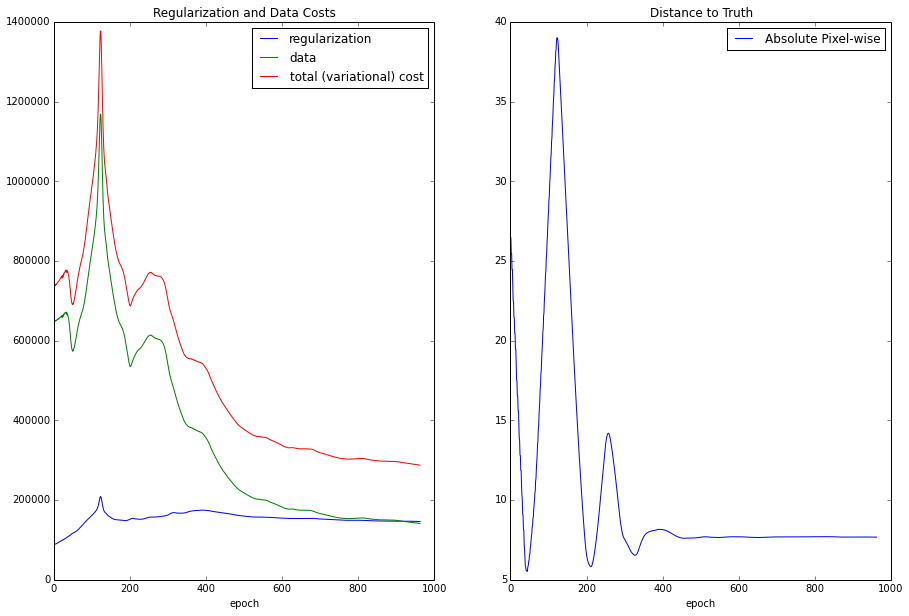

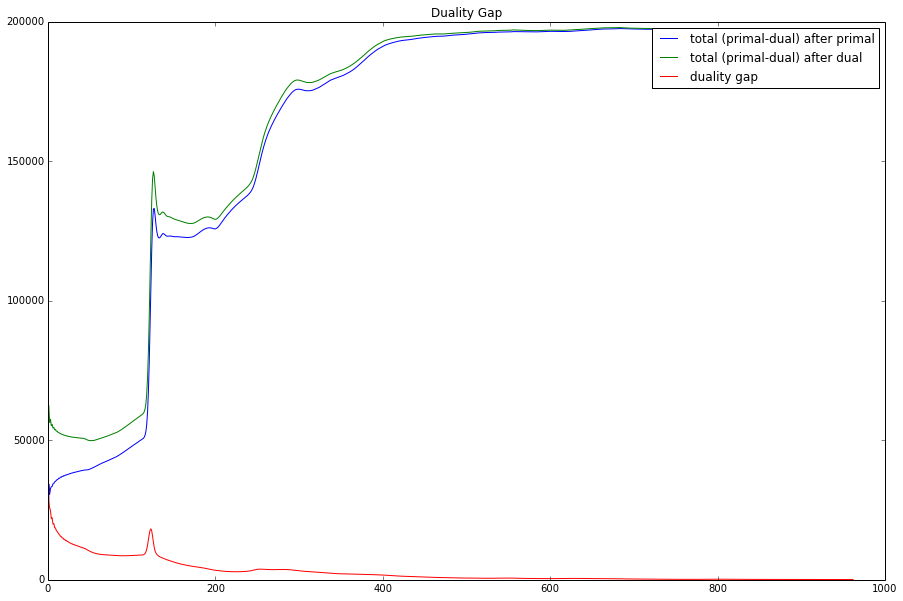

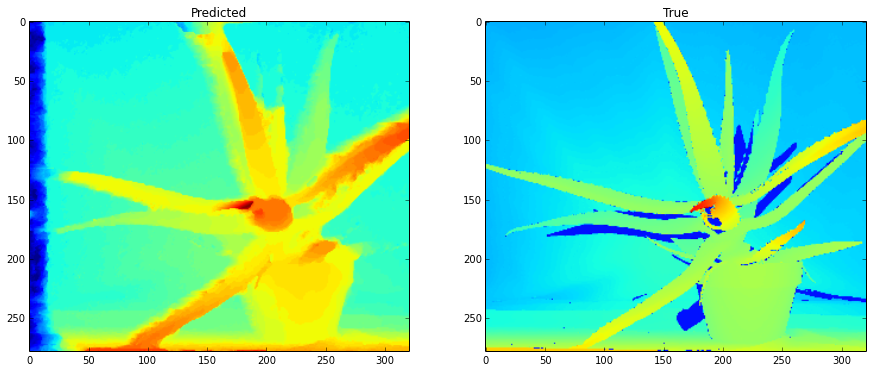

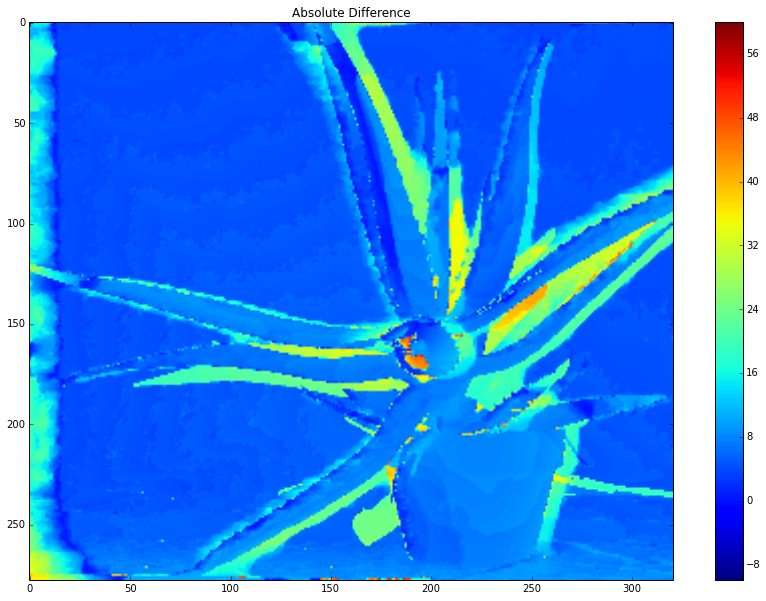

In [5]:
plot_summary(stereo, depth)

In [ ]:
# TEST - Get RHO
def plot_rho(rho, gammas, stride=1):
    show_gammas = list(enumerate(gammas[::stride]))
    cols = 3
    for offset, (i, gamma) in enumerate(show_gammas):
        col = offset % cols
        if col == 0:
            plt.figure()
        plt.subplot(1, cols, 1+col)

        plt.imshow(rho[:, :, i])
        plt.title('Gamma = {}px'.format(gamma))
        offset += 1
        
rho = compare(left, right, gammas)
plot_rho(rho, gammas, 6)
plt.figure()
plt.title('Min of Rho over all possible disparities')
plt.imshow(np.min(np.abs(rho), axis=2))

In [ ]:

"""
def get_norm_grad(im, eps):
    '''
    im (height, width, channel)
    ->
    grad (height, width, channel, direction)
    '''
    grads = np.gradient(im)
    grad_y, grad_x = grads[0], grads[1]
    grad = np.concatenate((grad_y[..., np.newaxis], 
                    grad_x[..., np.newaxis]),
                   axis=-1)
    amp = np.sqrt(eps**2 + (grad**2).sum(axis=-1, keepdims=True))
    norm_grad = grad / amp
    return norm_grad

def get_div(im):
    '''
    im (height, width, channel, direction)
        ->
    div (height, width, channel)
    '''
    grads = np.gradient(im)
    dy, dx = grads[0], grads[1]
    div = dy[..., 0] + dx[..., 1]
    return div

eps = 0.02

norm_grad = get_norm_grad(left, eps)
div = get_div(norm_grad)

plt.subplot(221)
plt.imshow(norm_grad[:, :, :, 0])

plt.subplot(222)
plt.imshow(norm_grad[:, :, :, 1])

plt.subplot(223)
plt.imshow(div)
"""


In [ ]:
u = np.zeros((left.shape[0], left.shape[1]))
v = np.zeros((left.shape[0], left.shape[1]))

In [ ]:
# Alternate Scheme
# minimize wrt u and v:
# TV(u) + 1/(2*theta) ||u-v||^2 + sum_i,j phi(v_i,j)
theta = 10
epsilon = 0.02
step = 0.1

du = []
dv = []

for epoch in xrange(20):
    print 'epoch', epoch
    du.append(np.linalg.norm(depth-u))
    dv.append(np.linalg.norm(depth-v))
    print 'u distance', du[-1]
    print 'v distance', dv[-1]
    # minimize u
    for epoch_u in xrange(40):
        norm_grad = get_norm_grad(u, epsilon)
        div = get_div(norm_grad)
        grad_u = -div + (u-v) / theta
        u -= step * grad_u

    # minimize v
    v_values = np.linspace(0, 50, 50)
    for i in xrange(v.shape[0]):  # iterate on rows only
        for j in xrange(v.shape[1]):
            #right_warped = np.take(right, j + v_values.astype(int), axis=1, mode='clip')
            scores = ((u[i, j] - v_values)**2 / 
                      (2*theta) + np.sum(np.abs(left[i,j] - 
                        np.take(right[i], j-v_values.astype(int), axis=0, mode='clip')),
                        axis=1))
            v[i, j] = v_values[np.argmax(scores)]


plt.imshow(u, cmap='gray')
plt.figure()
plt.imshow(v, cmap='gray')
plt.figure()
plt.imshow(depth, cmap='gray')
plt.figure()
plt.plot(np.arange(len(du)), du, label='distance u')
plt.plot(np.arange(len(dv)), dv, label='distance v')
plt.legend()

In [ ]:
depth.min()

In [ ]:
v.min()

In [ ]:
# Try to denoise
current = np.array(left)

In [ ]:
norm_grad = get_norm_grad(current, eps)
div = get_div(norm_grad)
current += 0.3 * div
plt.imshow(current)

In [ ]:
norm_grad.